In [21]:
# gradient_shap.ipynb
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

# ViT SHAP

In [22]:
import torch
from models.vit import get_vit_model, get_vit_model_with_hooks
from data.data import get_imagenette_dataloader
from gradient_utils.gradient_shap_utils import compute_shap_values, visualize_shap
from gradient_utils.vit_utils import visualize_attention_map

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
vit_model = get_vit_model(model_name='vit_base_patch16_224', pretrained=True, num_classes=10)

In [19]:
dataloader = get_imagenette_dataloader(batch_size=10, img_size=224)
images, labels = next(iter(dataloader))
device = next(vit_model.parameters()).device
images = images.to(device)

img_idx = 0

Imagenette already exists, skipping download.


## Generate Shapley Values w/ Overlay

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SHAP value range before normalization: min=0.0002460526802332863, max=0.005122500519959977
Normalized SHAP value range: min=0.0, max=1.0


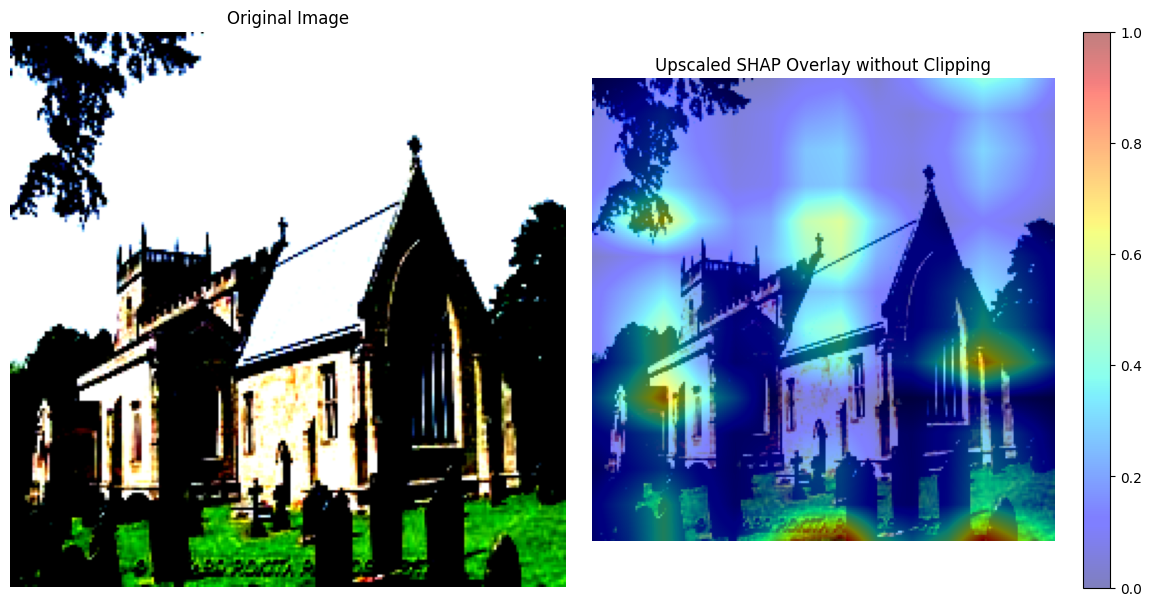

In [20]:
shap_values = compute_shap_values(vit_model, images)
original_image = images[img_idx].cpu().numpy().transpose((1, 2, 0))

visualize_shap(
    shap_values,
    original_image,
    patch_size=16
)

## Create Attention Maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


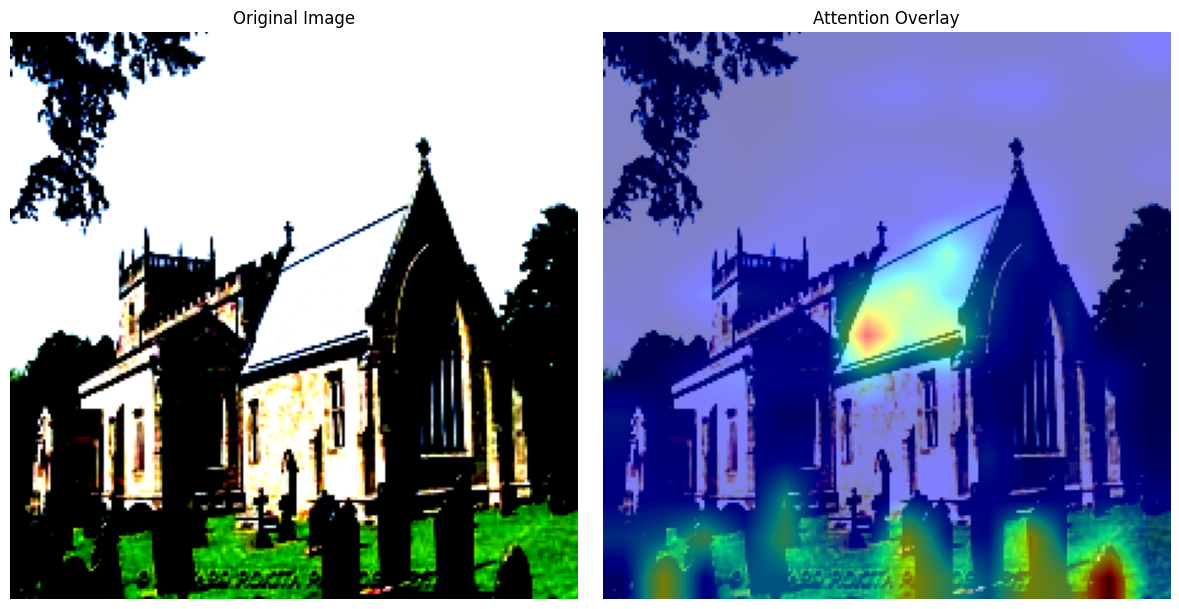

In [21]:
model_hook, attention_maps = get_vit_model_with_hooks(model_name='vit_base_patch16_224', pretrained=True, num_classes=10)

with torch.no_grad():
    _ = model_hook(images)

visualize_attention_map(images[img_idx], attention_maps) # let's compare attention map with shapley vis

## Initial Observations
1. The highlighted regions seem significantly more localized in the attention map, specifically focusing on certain structural regions of the church and each of the tombstones. The SHAP overlay, on the other hand, seem more sparse, suggesting a broader importance across the entire image.

2. The influence seems more maximal and focused in the attention map, whereas a more continuous gradient can be observed for the SHAP overlay. Though this may simply be due to the bilinear interpolation step when constructing the overlay.

### Conclusion
The SHAP overlay illustrates how ViTs utilize global information, showing that importance is distributed across the image rather than focusing on a single dominant feature. This holistic approach allows ViTs to capture long-range dependencies, where even seemingly irrelevant patches—like background elements—can subtly influence predictions by providing crucial context. Unlike attention maps, which highlight localized relationships, the SHAP overlay reflects the overall contribution after aggregating information from multiple attention heads and layers, giving a broader, more integrated view of how the model makes decisions.

# 3d-ResNet SHAP

In [20]:
from models.resnet_3d import get_resnet_3d_model
from data.data import get_ucf101_dataloader

In [4]:
resnet_3d_model = get_resnet_3d_model(pretrained=True, num_classes=10)

In [5]:
dataloader = get_ucf101_dataloader(batch_size=4, img_size=112, data_dir='../data', num_frames=16)
video_batch, _ = next(iter(dataloader))

v_ApplyEyeMakeup_g01_c01.avi already exists, skipping download.
v_ApplyEyeMakeup_g01_c02.avi already exists, skipping download.
v_BoxingPunchingBag_g01_c01.avi already exists, skipping download.
v_BoxingPunchingBag_g01_c02.avi already exists, skipping download.
annotations already downloaded, skipping download
annotations already extracted, skipping extraction
found 4 video files


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 12.92it/s]

reassigning manually initialized videoclips
reassigning samples and indices based on the manually initialized videoclips
skipping reshape, already in format: torch.Size([16, 3, 240, 320])
skipping reshape, already in format: torch.Size([16, 3, 240, 320])
skipping reshape, already in format: torch.Size([16, 3, 240, 320])



/home/kaiwen/.local/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


skipping reshape, already in format: torch.Size([16, 3, 240, 320])


## Generate Shapley Values w/ Overlay

In [6]:
shap_values = compute_shap_values(
    model=resnet_3d_model,
    inputs=video_batch,
    model_type="3d_resnet"
)

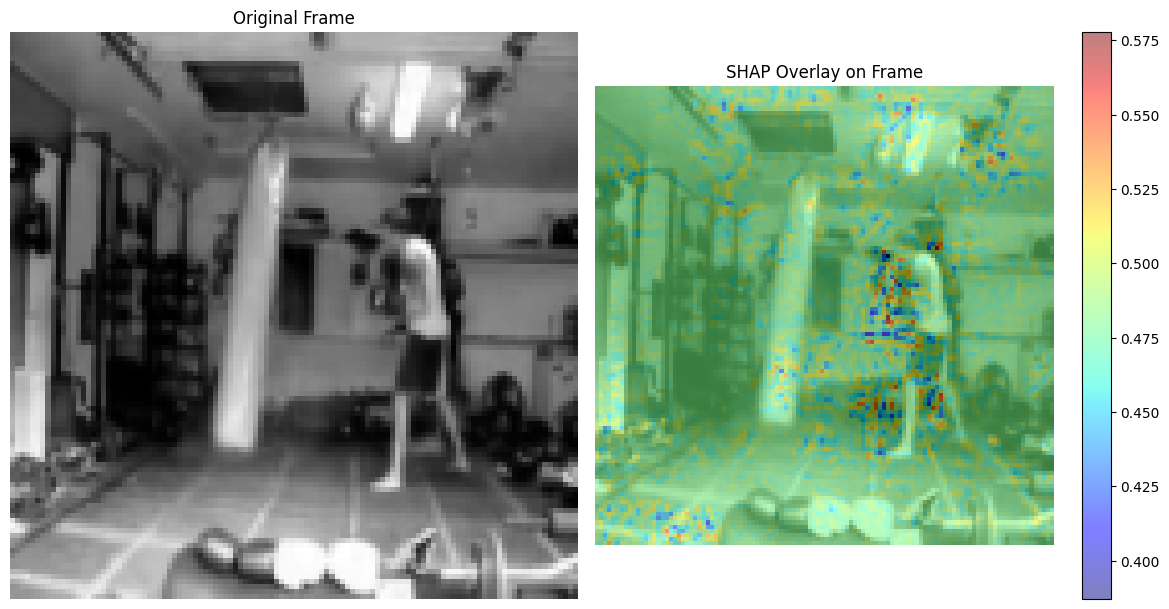

In [10]:
visualize_shap(
    shap_values=shap_values, 
    original_input=video_batch, 
    model_type="3d_resnet", 
    frame_idx=0
)

### Comparing 3D ResNet SHAP Overlay with ViT SHAP Overlay

1. The 3D ResNet overlay shows more concentrated areas of importance, hinting that the model focuses more on local features and patterns, accurately reflecting the localized receptive fields of CNNs. It additionally focuses on distinct, localized spatial features, aligning with CNNs tendency to focus on edges, corners, and smaller details rather than global features.

2. The 3D ResNet overlay's importance regions are tied to the motion in video frames, resulting in highly localized areas of importance. For example, it's clear that the SHAP overlay is sharply highlighting regions prone to movement over static regions (i.e. background), unlike the ViT SHAP overlay.